# Can ConvNets See Why Paris Looks Like Paris?

How do we recognize the look and feel of a city? A [2012 paper](http://graphics.cs.cmu.edu/projects/whatMakesParis/paris_sigg_reduced.pdf) argues our impression of "what makes Paris look like Paris" depends on scenes that are common in Paris but not elsewhere. The paper proposes such scenes can be described by clusters of mid-level visual elements that are representative and discriminative of Paris. For instance this method found clusters of visual elements [such as](http://graphics.cs.cmu.edu/projects/whatMakesParis/images/teaser1.pdf),

> The emblematic street sign, a balustrade window, and the balcony support are all very indicative of Paris, while [...] the neoclassical columned entryway sporting a balcony, a Victorian window, and, of course, the cast iron railing are very much features of London.

The motivation for finding mid-level visual elements was [simply that](http://graphics.cs.cmu.edu/projects/discriminativeModeSeeking/nips2013.pdf),

> Unfortunately, most machine learning algorithms (with some notable exceptions, e.g. [[13]](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)) are not equipped to handle [visual data] directly, at the raw pixel level, making research on finding good visual representations particularly relevant and timely.

The machine learning algorithm referenced as the exception is a deep convolutional neural network (ConvNet) that does handle visual data starting at the raw pixel level. Which prompts our question: Will a ConvNet trained to recognize cities from scenes also develop mid-level visual elements similar to those found by the clustering method described earlier? Here we will also aim to improve upon a method to train the classifer using very little data.

# Dataset

We need a set of enough images to be representative of Paris. First we find the center of Paris and a bounding box around it:

In [515]:
import json
from urllib import urlopen
import numpy as np

maps_api = 'https://maps.googleapis.com/maps/api/geocode/json?address='
maps_key = 'YOUR_API_KEY'
city_name = 'paris,france'
url_response = urlopen(maps_api + city_name + '&key=' + maps_key).read()
url_response = json.loads(url_response.replace('\\n', ''))
# center of Paris
city_center = [url_response['results'][0]['geometry']['location']]
# bounding box
box_ne = [url_response['results'][0]['geometry']['bounds']['northeast']]
box_sw = [url_response['results'][0]['geometry']['bounds']['southwest']]
h_min = np.minimum(box_ne[0]['lat'],box_sw[0]['lat'])
h_max = np.maximum(box_ne[0]['lat'],box_sw[0]['lat'])
w_min = np.minimum(box_ne[0]['lng'],box_sw[0]['lng'])
w_max = np.maximum(box_ne[0]['lng'],box_sw[0]['lng'])
box_h = h_max - h_min
box_w = w_max - w_min

Let us try [Poisson disc sampling](https://en.wikipedia.org/wiki/Supersampling#Poisson_disc) using [Bridson's algorithm](https://www.cs.ubc.ca/~rbridson/docs/bridson-siggraph07-poissondisk.pdf) to find a uniform random sampling of locations for the area to be spanned by 1000 samples with each sample having a radius or minimum distance of 100 m or 0.0009 degrees in Paris corresponding to the dimensions of a [city block](https://en.wikipedia.org/wiki/City_block). We use 30 candidate samples per iteration as proposed by Bridson. These parameters were chosen to eventually train the classifer on little data. 

In [626]:
ncandidates = 30
r_min = 0.0009
r_max = 2 * r_min
# background grid at most one sample per grid space
grid_dim = r_min / np.sqrt(2)
# sample list
samples = np.zeros((1000,5))
# first point
sample_valueX = center[0]['lng'] - w_min
sample_valueY = center[0]['lat'] - h_min
sample_indexX = np.ceil(sample_valueX / grid_dim)
sample_indexY = np.ceil(sample_valueY / grid_dim)
samples[0][0] = sample_indexX
samples[0][1] = sample_indexY
samples[0][2] = sample_valueX
samples[0][3] = sample_valueY
# fifth dimension shows active status
samples[0][4] = 1
# remaining points
i = 1
while i < samples.shape[0]:
    # annulus center
    samples_active = np.where(samples[:,4] == 1)[0]
    samples_active = np.random.permutation(samples_active)[0]
    center_indexX = samples[samples_active][0]
    center_indexY = samples[samples_active][1]
    center_valueX = samples[samples_active][2]
    center_valueY = samples[samples_active][3]
    for j in range(0,ncandidates):
        # uniform random sampling within annulus
        # theta can be uniformally sampled from [0,2pi]
        theta = np.random.uniform(0,2 * np.pi)
        # radius must be uniformally sampled from integrating CDF
        # CDF = k * \int_{r_min}^{r_max} r dr = k * 1/2*(r_max^2 - r_min^2)
        # normalizing CDF
        k_factor = 2 * 1 / (r_max ** 2 - r_min ** 2)
        # inverting for radius
        radius = np.sqrt(2 * np.random.uniform(0,1) / k_factor + r_min ** 2)
        candidate_valueX = center_valueX + radius * np.cos(theta)
        candidate_valueY = center_valueY + radius * np.sin(theta)
        # rejection sampling
        candidate_indexX = np.ceil(candidate_valueX / grid_dim)
        candidate_indexY = np.ceil(candidate_valueY / grid_dim)
        logicalX = (np.logical_and(samples[:,0] >= candidate_indexX - 2,samples[:,0] <= candidate_indexX + 2))
        logicalY = (np.logical_and(samples[:,1] >= candidate_indexY - 2,samples[:,1] <= candidate_indexY + 2))
        rejection = np.where(np.logical_and(logicalX,logicalY))[0]
        for k in range(rejection.shape[0]):
            diffX = candidate_valueX - samples[rejection[k]][2]
            diffY = candidate_valueY - samples[rejection[k]][3]
            distance_exception = 0
            if np.sqrt((diffX) ** 2 + (diffY) ** 2) < r_min:
                distance_exception = 1
                break
        if distance_exception == 0:
            samples[i][0] = candidate_indexX
            samples[i][1] = candidate_indexY
            samples[i][2] = candidate_valueX
            samples[i][3] = candidate_valueY
            samples[i][4] = 1
            i = i + 1
            break
        if distance_exception == 1 and j == 29:
            samples[samples_active][4] = 0
            break

Here are all the locations:

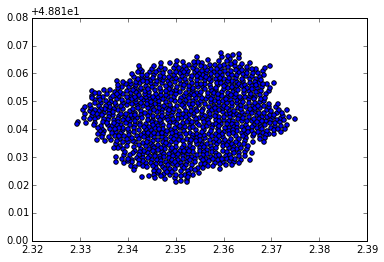

In [630]:
import matplotlib.pyplot as plt
%matplotlib inline

samplesX = samples[:,2] + w_min
samplesY = samples[:,3] + h_min
plt.scatter(samplesX,samplesY)

Here are the first 50 locations plotted on a map: 

In [632]:
from IPython.display import Image

samples_string = ''
for i in range(50):
    latlng = str(samples[i][3] + h_min) + ',' + str(samples[i][2] + w_min)
    samples_string = samples_string + latlng + '%7C'
static_api = 'https://maps.googleapis.com/maps/api/staticmap?&size=400x400&markers=size:tiny%7Ccolor:red%7C'
static_key = 'YOUR_API_KEY'
url_string = static_api + samples_string + '&key=' + static_key
Image(url=url_string, width = 400)

Now we need street-level scenes at each location. The commands for this are also found in the Google API Console. Once a street-level image is taken at each location, we can expand the analysis to other cities. Finally, when that data is collected, we can start to experiment with a classifier design that can reliably distinguish "Paris" from "not Paris" from very little data. (There are techniques that have been attempted before with some success [here](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html).) Clearly there is still a lot of work to be done, but hopefully this gives a starting point for analysis (the alternative of course being to get access to a real computing cluster).